# Visualise Trained Pytorch model and results

## Import libraries and plot training

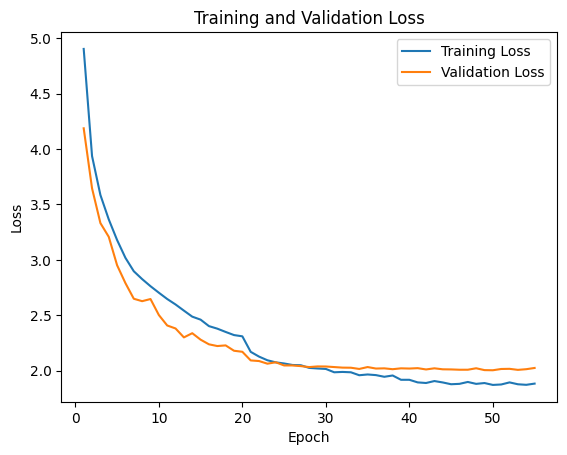

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import pandas as pd
from anytree import Node
from anytree.importer import JsonImporter
import torch.nn as nn
from collections import defaultdict
from torch.utils.data import Dataset, DataLoader
import numpy as np
from PIL import Image
from models.hierarchical_cnn import HierarchicalCNN
from utils.custom_dataset import CustomDataset

# Read the training log file
training_log = pd.read_csv('/mnt/RAID/projects/FjordVision/logs-coco/model_alpha_05.csv')

# Plot the training and validation loss
plt.plot(training_log['Epoch'], training_log['Training Loss'], label='Training Loss')
plt.plot(training_log['Epoch'], training_log['Validation Loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Extract test data

In [2]:
# %%
df = pd.read_parquet('/mnt/RAID/projects/FjordVision/coco-segmented-objects-dataset.parquet')

# Assuming df is your DataFrame with all data
train_val_df, test_df = train_test_split(df, test_size=0.3, random_state=42)

# Load The Model and Ontology

In [3]:
# Populate Taxonomy
importer = JsonImporter()
with open('/mnt/RAID/projects/FjordVision/data/coco.json', 'r') as f:
    root = importer.read(f)

classes_file = '/mnt/RAID/datasets/coco/classes.txt'

object_names = []
with open(classes_file, 'r') as file:
    object_names = [line.strip() for line in file]

subcategory_names, category_names, binary_names = [], [], []
for node in root.descendants:
    if node.rank == 'subcategory':
        subcategory_names.append(node.name)
    elif node.rank == 'category':
        category_names.append(node.name)
    elif node.rank == 'binary':
        binary_names.append(node.name)

class_name_lists = [binary_names, category_names, subcategory_names, object_names]
                    
# Create a defaultdict to store the counts for each rank
rank_counts = defaultdict(int)

# Iterate over the nodes of the tree
for node in root.descendants:
    rank = node.rank
    rank_counts[rank] += 1

# Example instantiation of the model
num_classes_hierarchy = list(rank_counts.values())  # Example: [num_species, num_genus, num_class, num_binary]
num_additional_features = 3  # Assuming 3 additional features: conf, iou, pred_species

model = HierarchicalCNN(num_classes_hierarchy, num_additional_features)
model.load_state_dict(torch.load('/mnt/RAID/projects/FjordVision/models/weights/coco-best_model_alpha_05.pth'))

<All keys matched successfully>

In [ ]:
from anytree.importer import JsonImporter
from collections import defaultdict
import torch

# Define the function in your notebook
def get_hierarchical_labels(species_index, species_names, genus_names, class_names, binary_names, root):
    if species_index == -1:
        return -1, -1, -1  # Handle cases where species_index is invalid

    species_name = species_names[species_index]
    node = next((n for n in root.descendants if n.name == species_name), None)

    if node is None:
        return -1, -1, -1  # Species not found in the tree

    # Initialize indices
    genus_index, class_index, binary_index = -1, -1, -1
    
    # Traverse up the tree to find the indices
    current_node = node
    while current_node.parent is not None:
        current_node = current_node.parent
        if current_node.rank == 'subcategory':
            genus_index = genus_names.index(current_node.name) if current_node.name in genus_names else -1
        elif current_node.rank == 'category':
            class_index = class_names.index(current_node.name) if current_node.name in class_names else -1
        elif current_node.rank == 'binary':
            binary_index = binary_names.index(current_node.name) if current_node.name in binary_names else -1

    return genus_index, class_index, binary_index


# Iterate through all object names and check which ones return -1 for any rank
for object_name in object_names:
    species_index = object_names.index(object_name) if object_name in object_names else -1
    genus_index, class_index, binary_index = get_hierarchical_labels(species_index, object_names, subcategory_names, category_names, binary_names, root)
    
    # Check if any of the indices are -1
    if genus_index == -1 or class_index == -1 or binary_index == -1:
        print(f"Object Name: {object_name} - Genus Index: {genus_index}, Class Index: {class_index}, Binary Index: {binary_index}")

# Load Dataloader

In [ ]:
test_dataset = CustomDataset(test_df, object_names, subcategory_names, category_names, binary_names, root)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Extract Predictions on test data

In [ ]:
(test_df['predicted_species'] == test_df['species']).sum() / len(test_df)

In [ ]:
from sklearn.metrics import f1_score
import numpy as np

# Initialize lists to store true labels and predictions for each level
true_labels = {level: [] for level in ['binary', 'category', 'subcategory', 'object']}
predictions = {level: [] for level in ['binary', 'category', 'subcategory', 'object']}

model.eval()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

model.eval()
with torch.no_grad():
    for images, conf, iou, pred_species, species_index, genus_index, class_index, binary_index in test_loader:
        images, conf, iou, pred_species = images.to(device), conf.to(device), iou.to(device), pred_species.to(device)
        
        outputs = model(images, conf, iou, pred_species)
        
        # Convert model outputs to predictions
        for i, output in enumerate(outputs):  # For each hierarchical level
            _, predicted = torch.max(output, 1)
            level = ['binary', 'category', 'subcategory', 'object'][i]
            predictions[level].extend(predicted.cpu().numpy())
        
        # Store true labels
        true_labels['binary'].extend(binary_index.cpu().numpy())
        true_labels['category'].extend(class_index.cpu().numpy())
        true_labels['subcategory'].extend(genus_index.cpu().numpy())
        true_labels['object'].extend(species_index.cpu().numpy())

In [ ]:
f1_scores = {}
for level in ['binary', 'category', 'subcategory', 'object']:
    f1_scores[level] = f1_score(true_labels[level], predictions[level], average='macro')
    print(f"F1 Score for {level}: {f1_scores[level]:.4f}")

# Visualise CNN

In [ ]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
import torchvision.transforms.functional as F

# Assume necessary imports and model definition are done here

def transform_activations(activations):
    """
    Transforms activations from (C x B x H x W) to (B x C x H x W).
    Specifically handles the case where C should be treated as B for visualization.
    """
    B, C, H, W = activations.shape[1], 1, activations.shape[2], activations.shape[3]
    return activations.permute(1, 0, 2, 3).view(B, C, H, W)

def resample_activations_to_grid(activations, nrow=4):
    """
    Ensures there are nrow*nrow activation maps by either repeating or subsetting.
    Adjusted for a 4x4 grid.
    """
    total_needed = nrow * nrow  # Adjusted for a 4x4 grid
    current_count = activations.shape[0]

    if current_count < total_needed:
        repeats = total_needed // current_count + 1
        activations = activations.repeat(repeats, 1, 1, 1)[:total_needed]
    elif current_count > total_needed:
        indices = torch.linspace(0, current_count - 1, total_needed).long()
        activations = activations[indices]

    return activations

def visualize_hierarchical_predictions_and_activations(image, activations, true_labels, predictions, class_name_lists, file_name):
    fig, axs = plt.subplots(1, 5, figsize=(20, 4))  # Adjusted subplot size for better visualization
    levels = ['original', 'binary', 'class', 'genus', 'species']

    # Original image visualization
    img_np = np.transpose(image.cpu().numpy(), (1, 2, 0))
    img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min())
    axs[0].imshow(img_np)
    axs[0].axis('off')

    # Visualize activations for each level
    for i, level in enumerate(levels):
        if i == 0: continue
        current_activation = activations[i - 1]
        current_activation = transform_activations(current_activation)
        current_activation = resample_activations_to_grid(current_activation, nrow=4)  # Ensure 4x4 grid
        activation_grid = make_grid(current_activation, nrow=4, normalize=True, padding=2)

        # Directly convert the grid tensor to a NumPy array and apply cmap
        grid_np = np.transpose(activation_grid.cpu().numpy(), (1, 2, 0))
        axs[i].imshow(grid_np[:, :, 0], cmap='viridis')  # Ensures viridis is applied for single-channel images
        axs[i].axis('off')

    plt.tight_layout()
    plt.savefig(file_name)  # Save the figure
    plt.close()  # Close the plot to free memory

# Define alpha values
alpha_values = [0.5]

# Create the main directory for activations if it doesn't exist
os.makedirs('activations', exist_ok=True)

# Loop through each alpha value
for alpha in alpha_values:
    # Adjust the alpha value for file naming convention
    alpha_str = str(alpha).replace('.', '')
    alpha_dir = f'activations/alpha_{alpha_str}'
    os.makedirs(alpha_dir, exist_ok=True)
    
    # Loop through each species
    for idx, species in enumerate(object_names):
        # Modify the model loading path to include the current alpha value
        model_path = f'/mnt/RAID/projects/FjordVision/models/weights/coco-best_model_alpha_{alpha_str}.pth'
        
        # Load and prepare the model for each species
        model = HierarchicalCNN(num_classes_hierarchy, num_additional_features)
        model.load_state_dict(torch.load(model_path))
        model.eval()
        model.to(device)
        model.register_hooks()

        # Get one random sample from the DataLoader
        for images, conf, iou, pred_species, species_index, genus_index, class_index, binary_index in test_loader:
            if species_index[0].item() == idx:
                selected_image = images[0].unsqueeze(0).to(device)
                selected_conf = conf[0].unsqueeze(0).to(device)
                selected_iou = iou[0].unsqueeze(0).to(device)
                selected_pred_species = pred_species[0].unsqueeze(0).to(device)
                _ = model(selected_image, selected_conf, selected_iou, selected_pred_species)
                break

        # Create a directory for the species within the alpha directory if it doesn't exist
        species_dir = os.path.join(alpha_dir, species.replace(" ", "_"))
        os.makedirs(species_dir, exist_ok=True)

        # Generate and save the activation visualizations in the species directory
        file_name = os.path.join(species_dir, f'{species.replace(" ", "_")}.png')
        visualize_hierarchical_predictions_and_activations(
            selected_image.squeeze(0), 
            model.activations, 
            {'binary': binary_index[0].item(), 'category': class_index[0].item(), 'subcategory': genus_index[0].item(), 'object': species_index[0].item()}, 
            predictions, 
            class_name_lists,
            file_name  # Pass the file name where the image should be saved
        )

# Find Segmentation of Selected Class

# Visualise most likely classes

In [4]:
import os
import torch
import torch.optim as optim
import numpy as np
import cv2
import matplotlib.pyplot as plt

torch.cuda.empty_cache()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the parameters for the image optimization process
upscaling_steps = 15
upscaling_factor = 1.2
lr = 0.01

# Load the model
alphas = ['05']
levels = ['binary', 'category', 'subcategory', 'object']
class_levels = [binary_names, category_names, subcategory_names, object_names]

# Create the main directory for class activations
os.makedirs('class-activations', exist_ok=True)

for alpha in alphas:
    model_path = f'/mnt/RAID/projects/FjordVision/models/weights/coco-best_model_alpha_{alpha}.pth'
    model.load_state_dict(torch.load(model_path))
    model.to(device)
    model.eval()

    for level_index, level in enumerate(levels):
        level_path = os.path.join('class-activations', level)
        os.makedirs(level_path, exist_ok=True)

        for class_name in class_levels[level_index]:
            class_path = os.path.join(level_path, class_name.replace(" ", "_"))
            os.makedirs(class_path, exist_ok=True)

            # Initialize the image tensor once before the loop
            image = torch.randn(1, 3, 50, 50, device=device, requires_grad=True)

            for step in range(upscaling_steps):
                optimizer = optim.Adam([image], lr=lr)

                for iteration in range(30):
                    optimizer.zero_grad()
                    outputs = model(image, torch.tensor([0.0], device=device), torch.tensor([0.0], device=device), torch.tensor([0.0], device=device))
                    target_class_index = class_levels[level_index].index(class_name)
                    target_output = outputs[level_index]

                    loss = -target_output[0, target_class_index]
                    loss.backward()
                    optimizer.step()

                    # Delete intermediate tensors
                    del outputs, target_output, loss

                # Upscale the image tensor
                if step < upscaling_steps - 1:
                    size = int(50 * (upscaling_factor ** (step + 1)))
                    image = image.detach().cpu().numpy()
                    image = np.transpose(image, (0, 2, 3, 1))
                    image = cv2.resize(image[0], (size, size), interpolation=cv2.INTER_LINEAR)
                    image = np.transpose(image, (2, 0, 1))
                    image = torch.from_numpy(image).unsqueeze(0).to(device)
                    image.requires_grad_(True)

            # Process and save the final image
            image_np = image.detach().cpu().squeeze().numpy()
            image_np = np.transpose(image_np, (1, 2, 0))
            image_np = (image_np - image_np.min()) / (image_np.max() - image_np.min())
            image_filename = os.path.join(class_path, f'{class_name.replace(" ", "_")}_alpha_{alpha}.png')
            plt.imsave(image_filename, image_np)